
read train & test data from csv file


Best parameters set found on development set:
{'model__n_neighbors': 4}
C:  RMSE, MAE, R^2 = 16.875, 10.620, 0.816


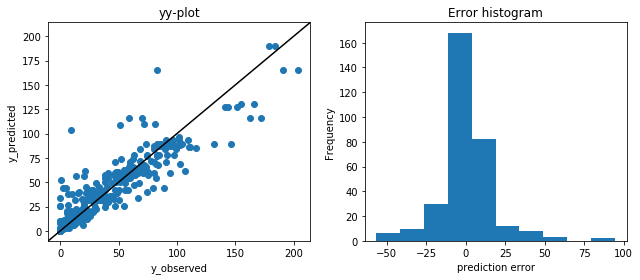

CV: RMSE, MAE, R^2 = 25.930, 16.298, 0.565


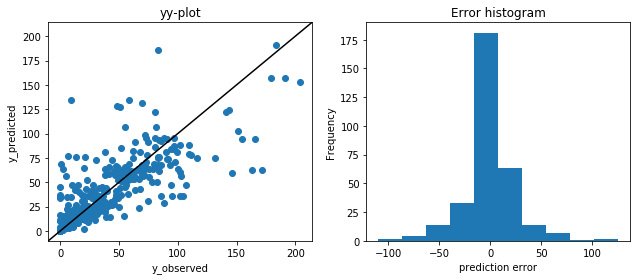

P:  RMSE, MAE, R^2 = 33.672, 22.438, 0.000


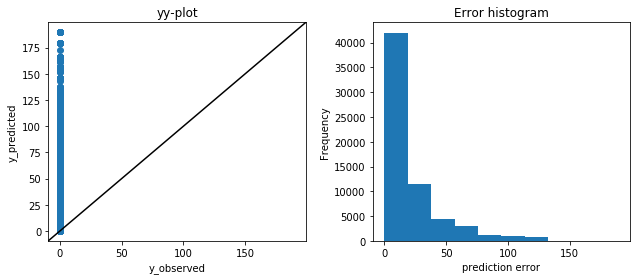


Predicted Tc is written in file test2_Tc_kNN_AD_DCV.csv

Double Cross Validation
In 10 iterations, average +/- standard deviation
RMSE DCV: 37.205 (+/-0.701)
MAE  DCV: 27.085 (+/-0.781)
R^2  DCV: 0.105 (+/-0.034)
34.21 seconds 


In [7]:
# -*- coding: utf-8 -*-
"""
Hydride Tc Regression

1. Hydride Tc Regression (k-NN)
2. Applicability Domain (k-NN)
3. Double Cross Validation

Created on Fri Sep  7 14:35:49 2018

@author: Akitaka

Parameters
----------
Nothing

Returns
-------
Nothing

Input file
----------
tc_train.csv:
    Tc, atomic number 1&2, the number of atoms 1&2, pressure 
    of already calculated materials

tc_test.csv:
    Tc, atomic number 1&2, the number of atoms 1&2, pressure 
    of XnHm (n,m=1,...,10): X=He~At (without rare gas)

Outnput file
------------
test2_Tc_kNN_AD_DCV.csv:
    chemical formula, P, Tc, AD


"""
%matplotlib inline
import pandas as pd
import numpy as np
from time                    import time
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.neighbors       import KNeighborsRegressor
from pymatgen                import periodic_table, Composition
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from my_library              import print_gscv_score_rgr, dcv_rgr, ad_knn

def read_xy_csv(name): 
    data = np.array(pd.read_csv(filepath_or_buffer=name,
                                index_col=0, header=0, sep=','))[:,:]
    y = data[:,0]
    X = data[:,1:]
    return X, y

start = time()

print()
print('read train & test data from csv file')
print()
train_file = 'tc_train.csv'
X_train, y_train = read_xy_csv(train_file)
test_file = 'tc_test.csv'
X_test, y_test = read_xy_csv(test_file)

# print statistics of database
if(False):
    data = pd.read_csv(filepath_or_buffer='tc_train.csv',
                       index_col=0, header=0, sep=',')
    data.drop('Z2', axis=1, inplace=True)
    print(data.describe())

range_k = np.arange(  3, 11, dtype=int)

# Set the parameters by cross-validation
scaler = MinMaxScaler()
scaler = StandardScaler()
model = KNeighborsRegressor()
pipe = Pipeline([('scaler', scaler),('model',  model)])
param_grid = [{'model__n_neighbors':range_k}]

n_splits = 5 
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2)
cv = KFold(n_splits=n_splits, shuffle=True)
gscv = GridSearchCV(pipe, param_grid, cv=cv)
gscv.fit(X_train, y_train)
print_gscv_score_rgr(gscv, X_train, X_test, y_train, y_test, cv)

# Prediction
y_pred = gscv.predict(X_test)

# Applicability Domain (inside: +1, outside: -1)
y_appd = ad_knn(X_train, X_test)

data = []
for i in range(len(X_test)):
    satom1 = periodic_table.get_el_sp(int(X_test[i][0])) 
    satom2 = periodic_table.get_el_sp(int(X_test[i][1])) 
    natom1 = int(X_test[i][2])
    natom2 = int(X_test[i][3])
    str_mat = str(satom1) + str(natom1) + str(satom2) + str(natom2)
    formula = Composition(str_mat).reduced_formula
    temp = (formula, int(X_test[i][4]), int(y_pred[i]),y_appd[i])
    data.append(temp)

properties=['formula','P', 'Tc', 'AD']
df = pd.DataFrame(data, columns=properties)
df.sort_values('Tc', ascending=False, inplace=True)

output = 'test2_Tc_kNN_AD_DCV.csv'
# df.to_csv(output, index=False)
df_in_ = df[df.AD ==  1]
df_in_.to_csv(output, index=False)
print('Predicted Tc is written in file {}'.format(output))

if(True):
    param_grid = [{'n_neighbors':range_k}]
    dcv_rgr(X_train, y_train, model, param_grid, 10)

print('{:.2f} seconds '.format(time() - start))
